<a href="https://colab.research.google.com/github/VIVEKPATIL12/secondWeb/blob/main/Potholes_Segmentation_U_net_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

! mkdir Data
! unzip -q /content/train.zip -d Data
! unzip -q /content/valid.zip -d Data




In [ ]:
import numpy as np
import pandas as pd
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet101
import matplotlib.pyplot as plt
import shutil
import random
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf

In [ ]:
source_img_path = r'/content/Data/Pothole_Segmentation_YOLOv8/train/images'
source_label_path = r'/content/Data/Pothole_Segmentation_YOLOv8/train/labels'
source_mask_path = r'/content/Data/Pothole_Segmentation_YOLOv8/train/masks'
## **Visualizing and preprocessing the data**
print(f"There are {len(os.listdir(source_img_path))} images of potholes.")
print(f"There are {len(os.listdir(source_label_path))} images of labels.")
len(os.listdir('/content/Data/Pothole_Segmentation_YOLOv8/train/images'))

There are 3807 images of potholes.
There are 3807 images of labels.


3807

In [ ]:

## **Generating the masks from the labels**
def maskGenerator(directory):
  img_dir = directory+'/images/'
  label_dir = directory+'/labels/'

  img_list = os.listdir(img_dir)
  label_list = os.listdir(label_dir)

  for i in range(len(img_list)):
    img_name = img_list[i]
    label_name = '.'.join(img_name.split('.')[:-1]) + '.txt'
    if label_name not in label_list:
      print(label_name)
      pass

    img = cv2.imread(img_dir + img_name)
    label = label_dir + label_name
    img_shape = img.shape
    mask = np.zeros(img_shape)

    file1 = open(label, 'r')
    while True:
      poly = file1.readline()
      if not poly:
        break
      s = poly.split()
      #only single class of segmentation so we dont care about classes
      coord = np.array(s[1:], dtype='float32').reshape(-1,2)
      coord[:,0] = coord[:,0]*np.array(img_shape[0])
      coord[:,1] = coord[:,1]*img_shape[1]
      coord = coord.astype('int32')

      cv2.fillPoly(mask, pts = [coord], color =(255,255,255))
    cv2.imwrite(directory+'/masks/'+img_list[i], mask)



maskGenerator('/content/Data/Pothole_Segmentation_YOLOv8/train')
maskGenerator('/content/Data/Pothole_Segmentation_YOLOv8/valid')

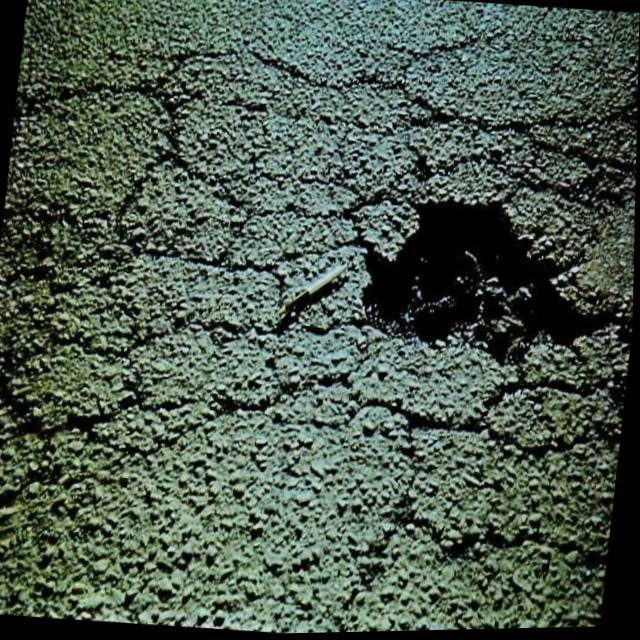

In [ ]:

## **Contd**
l_img = os.listdir(source_img_path)
l_mask = os.listdir(source_mask_path)

l_img[0]
x = 6
img_pot = cv2.cvtColor(cv2.imread(source_img_path+'/'+l_img[x]),cv2.COLOR_BGR2RGB)
mask_pot = cv2.cvtColor(cv2.imread(source_mask_path+'/'+l_mask[x]),cv2.COLOR_BGR2GRAY)

cv2_imshow(img_pot)
def apply_mask(img_pot, mask_pot):
  img = img_pot
  img[:,:,2] = cv2.bitwise_or(img_pot[:,:,2], mask_pot)
  return img


def make_pair(IMG_DIR,MASK_DIR=''):
  img_list = os.listdir(IMG_DIR)
  pairs = []
  if MASK_DIR!='':
    mask_list = os.listdir(MASK_DIR)

    for i in range(len(img_list)):
      img = IMG_DIR+img_list[i]
      mask = MASK_DIR+mask_list[i]
      pairs.append((img,mask))
  else:
    for i in range(len(img_list)):
      img = IMG_DIR+img_list[i]
      pairs.append((img,''))

  return pairs

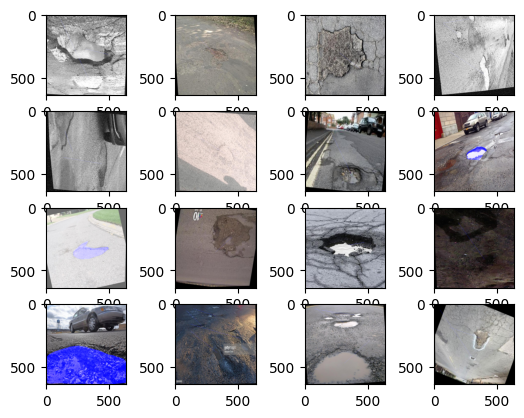

In [ ]:

POT_TRAIN_DIR = r'/content/Data/Pothole_Segmentation_YOLOv8/train/images/'
MASK_TRAIN_DIR = r'/content/Data/Pothole_Segmentation_YOLOv8/train/masks/'
len(os.listdir(MASK_TRAIN_DIR))
pair1 = make_pair(POT_TRAIN_DIR, MASK_TRAIN_DIR)
random.shuffle(pair1)
for i in range(16):
  i1 = cv2.cvtColor(cv2.imread(pair1[i][0]), cv2.COLOR_BGR2RGB)
  i2 = cv2.cvtColor(cv2.imread(pair1[i][1]), cv2.COLOR_BGR2GRAY)
  plt.subplot(4,4,i+1)
  plt.imshow(apply_mask(i1,i2))

class DataGenerator(keras.utils.Sequence):
  def __init__(self, pair, batch_size=16, dim=(224,224,3), shuffle=True):
    self.dim = dim
    self.pair = pair
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.pair))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __len__(self):
    return int(np.floor(len(self.pair) / self.batch_size))

  def generate_data(self, img_pos):
    img_batch = list()
    mask_batch = list()

    for i in img_pos:
      img = cv2.cvtColor(cv2.imread(self.pair[i][0]),cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (self.dim[0],self.dim[1]))
      if self.pair[i][1]!='':
        mask = cv2.cvtColor(cv2.imread(self.pair[i][1]),cv2.COLOR_BGR2GRAY)
      else:
        mask = np.zeros(img.shape[:-1])
      mask = cv2.resize(mask, (self.dim[0],self.dim[1]))
      img = img.astype('float32')/255.0
      mask = mask.astype('float32')/255.0
      img_batch.append(img)
      mask_batch.append(mask)

    return np.array(img_batch), np.array(mask_batch)

  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    img_pos = [i for i in indexes]
    X, y = self.generate_data(img_pos)
    return X, y

47

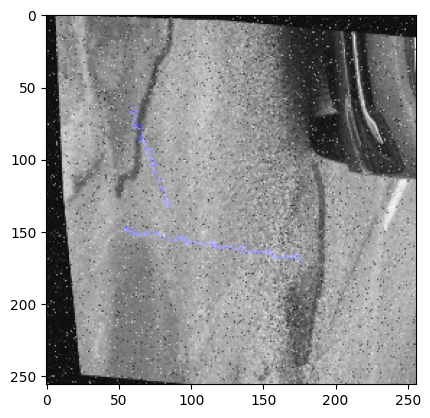

In [ ]:


split = 0.8
split_size = int(len(pair1)*split)
train_pairs = pair1[:split_size]
test_pairs = pair1[split_size:]
len(train_pairs[0])
train_generator = DataGenerator(pair = train_pairs, batch_size=16, dim=(256,256,3), shuffle=True)
train_generator.__len__()
img_pos = np.arange(16).tolist()
random.shuffle(img_pos)
b = train_generator.generate_data(img_pos=img_pos)
len(b)
b[1][10].dtype
plt.imshow(b[1][2])
plt.imshow(apply_mask(b[0][2],b[1][2]))
test_generator = DataGenerator(pair = test_pairs, dim=(256,256,3), shuffle=True)
test_generator.__len__()

In [ ]:




## **Defining the components of the U-Net model**

def doubleconv_block(x, n_filters):
  x = tf.keras.layers.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(x)
  x = tf.keras.layers.Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(x)
  return x
#defining the upsample blocks
#return the conv blocks too to facilitate the skip connections
def downsample_block(x, n_filters):
  f = doubleconv_block(x, n_filters)
  p = tf.keras.layers.MaxPooling2D()(f)
  p = tf.keras.layers.Dropout(0.1)(p)
  return f, p
#defining the upsample block for the decoder
#the upsample block also takes the skip connections from the encoder
def upsample_block(x, conv_features, n_filters):
  x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
  x = tf.keras.layers.Concatenate()([x,conv_features])
  x = tf.keras.layers.Dropout(0.1)(x)
  x = doubleconv_block(x, n_filters)
  return x

In [ ]:

def U_NET(input_shape, depth=3):
  f = []
  p = []
  inputs = tf.keras.layers.Input(shape=input_shape)
  pi = inputs
  filters = 64
  #encoder block
  for i in range(depth):
    filters *= 2
    fi, pi = downsample_block(pi, filters)
    f.append(fi)
    p.append(pi)

  #bottleneck
  bottleneck = doubleconv_block(pi, filters)

  #decoder block
  u = bottleneck
  for i in range(depth):
    filters //= 2  # Use integer division (//) to avoid floating-point values
    u = upsample_block(u, f[depth - i - 1], filters)
  #output of the mask alone
  #since we have only one class to segment, one filter is enough
  outputs = tf.keras.layers.Conv2D(2, 1, padding='same')(u)

  unet_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='U-Net')
  return unet_model

depth = 3
unet_model = U_NET(input_shape=(256,256,3), depth=depth)

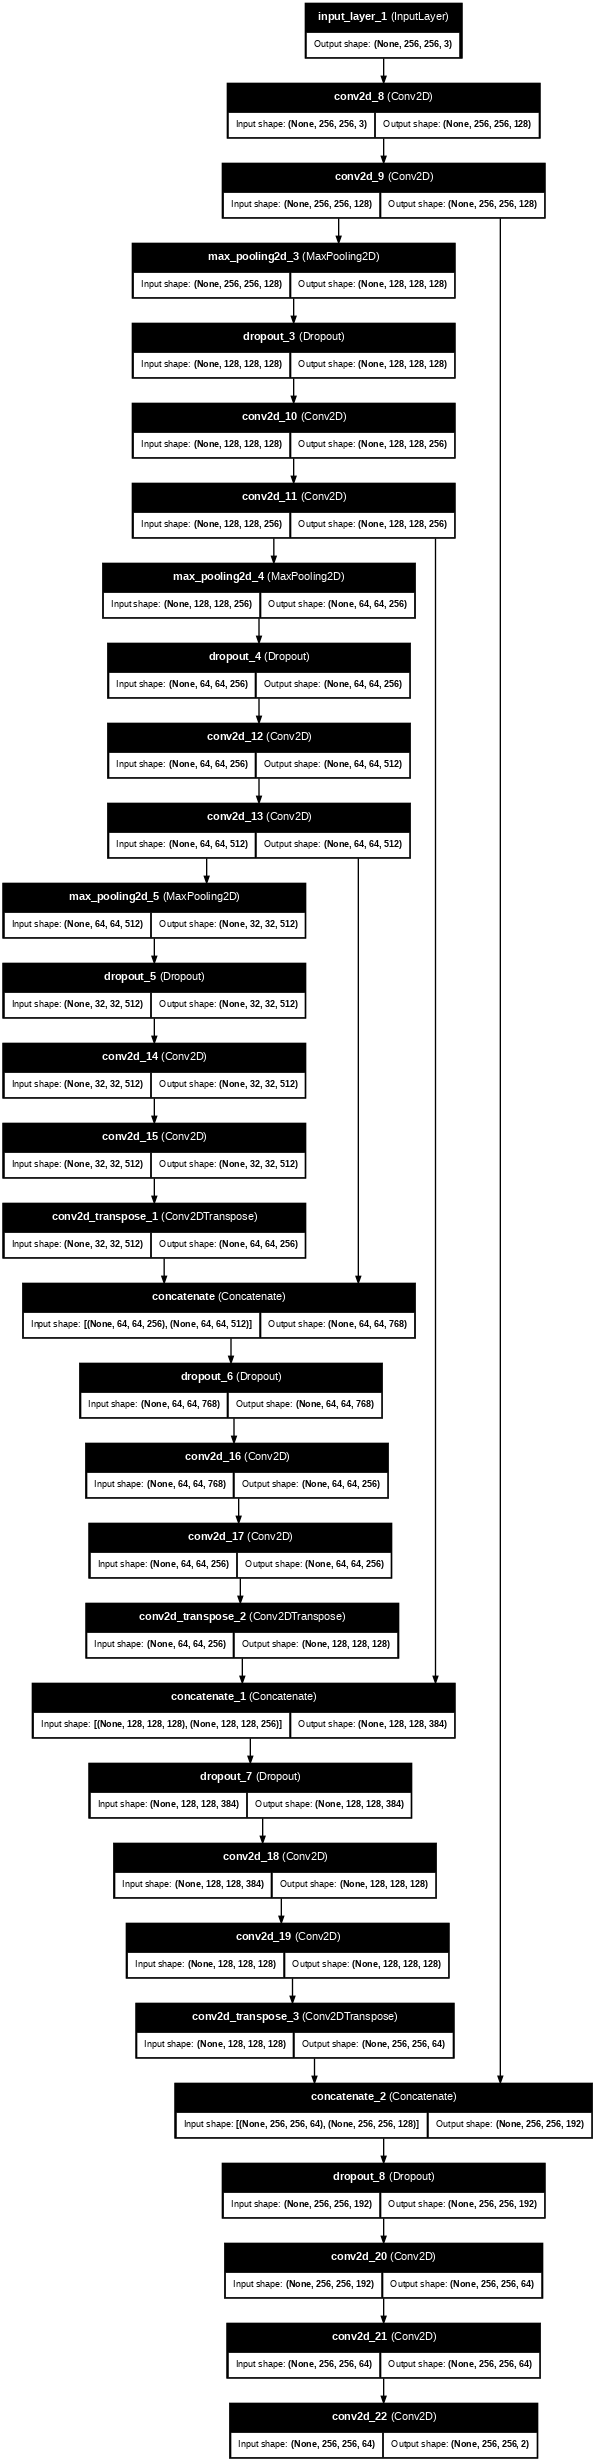

In [ ]:
tf.keras.utils.plot_model(unet_model,
                          to_file='/content/model' + str(depth) + '.png',
                          show_shapes=True,
                          show_dtype=False,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=48,
                          layer_range=None,
                          show_layer_activations=False,
                          show_trainable=False)

In [ ]:


#callbacks
earlyStop = keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0.005,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=55
)
callbacks = [earlyStop]
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])
### **Sample U-Net for depth=4**
history = unet_model.fit(train_generator,
                         steps_per_epoch=train_generator.__len__(),
                         epochs=100,
                         validation_data=test_generator,
                         validation_steps=test_generator.__len__(),
                         callbacks=callbacks)
unet_model.save('/content/my_model_all_Data.h5')
# files.download('/content/my_model.h5')


NameError: name 'keras' is not defined

In [ ]:
imgTest = cv2.cvtColor(cv2.imread('/content/pot3.jpg'), cv2.COLOR_BGR2RGB)
imgTest = cv2.resize(imgTest,(256,256)).astype('float32')/255.0
imgTest = np.array([imgTest])
plt.imshow(imgTest[0])
pred_mask = unet_model.predict(imgTest)
plt.imshow(apply_mask(imgTest[0], pred_mask[0][:,:,1]))